In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style("white")

## Reading Data

In [3]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("D:/Developer/Data Science/Projects/School_Project/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Reading Surveys

In [4]:
all_survey = pd.read_csv("D:/Developer/Data Science/Projects/School_Project/survey_all.txt", 
                         delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("D:/Developer/Data Science/Projects/School_Project/survey_d75.txt", 
                         delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", "rr_s", "rr_t", 
    "rr_p", "N_s", "N_t", 
    "N_p", "saf_p_11", "com_p_11", 
    "eng_p_11", "aca_p_11", "saf_t_11", 
    "com_t_11", "eng_t_11", "aca_t_11", 
    "saf_s_11", "com_s_11", "eng_s_11", 
    "aca_s_11", "saf_tot_11", "com_tot_11", 
    "eng_tot_11", "aca_tot_11"]

data["survey"] = survey.loc[:,survey_fields]

In [5]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results', 'survey'])

## Add DBN columns

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"]["DBN"]

0        01M015
1        01M015
2        01M015
3        01M015
4        01M015
          ...  
27606    32K564
27607    32K564
27608    32K564
27609    32K564
27610    32K564
Name: DBN, Length: 27611, dtype: object

## Convert Columns to Numeric

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [8]:
data["hs_directory"]["lat"]

0      40.670299
1      40.827603
2      40.842414
3      40.710679
4      40.718810
         ...    
430    40.854647
431    40.859698
432    40.875754
433    40.705235
434    40.734408
Name: lat, Length: 435, dtype: float64

In [9]:
data["hs_directory"]["lon"]

0     -73.961648
1     -73.904475
2     -73.916162
3     -74.000807
4     -73.806500
         ...    
430   -73.896646
431   -73.860741
432   -73.861388
433   -74.013315
434   -73.821417
Name: lon, Length: 435, dtype: float64

## Condense datasets

In [10]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP Scores to Numeric

In [11]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data["ap_2010"][c] = pd.to_numeric(data["ap_2010"][c], errors="coerce")

## Combine the datasets

In [12]:
combined = data["sat_results"]
#Left Join
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
#Inner Join
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797


## Add School District Column for Mapping

In [13]:
def first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(first_two_chars)
combined.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01


## Find Correlations

In [14]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

## Color Palettes

In [15]:
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
color1 = sns.color_palette("crest", as_cmap=True)
color2 = sns.color_palette("flare", as_cmap=True)
color3 = ['#143642', '#ec9a29', '#0f8b8d', '#a8201a']
color4 = sns.color_palette("viridis", as_cmap=True)
color5 = sns.color_palette("icefire", as_cmap=True)
color6 = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

## Plot Total Enrollment

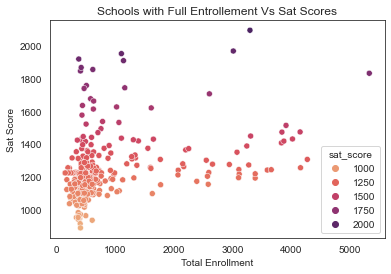

In [16]:
viz1 = sns.scatterplot(data= combined, x= 'total_enrollment', y= 'sat_score', hue='sat_score', 
                       palette= color2 )
plt.xlabel('Total Enrollment')
plt.ylabel('Sat Score')
plt.title('Schools with Full Entrollement Vs Sat Scores')
plt.show()

## Plot Schools with Low SAT Scores and Enrollment

In [17]:
# low_enrollment = combined[(combined['total_enrollment'] < 1000)]
# low_enrollment = combined[(combined['sat_score'] < 1000)]
# low_enrollment['School Name']

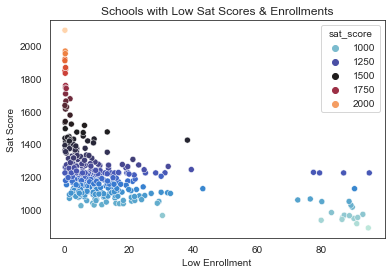

In [18]:
viz2 = sns.scatterplot(data= combined, x= 'ell_percent', y= 'sat_score', hue='sat_score', palette= color5)
plt.xlabel('Low Enrollment')
plt.ylabel('Sat Score')
plt.title('Schools with Low Sat Scores & Enrollments')
plt.show()

## Plot Survey Correlation

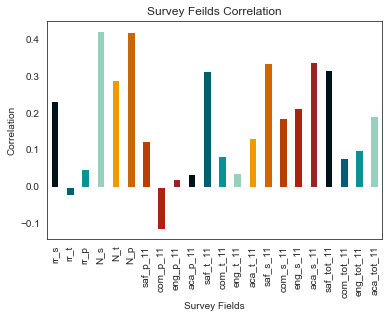

In [19]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
combined.corr()['sat_score'][survey_fields].plot.bar(color = colors)
plt.title('Survey Feilds Correlation')
plt.xlabel('Survey Fields')
plt.ylabel('Correlation')
plt.show()

## Safety and SAT Scores Exploration

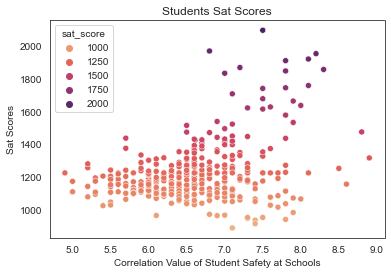

In [20]:
viz3 = sns.scatterplot(data= combined, x= 'saf_s_11', y= 'sat_score', hue= 'sat_score', palette= color2)
plt.title('Students Sat Scores')
plt.xlabel('Correlation Value of Student Safety at Schools')
plt.ylabel('Sat Scores')
plt.show()

## SAT scores on basis of community

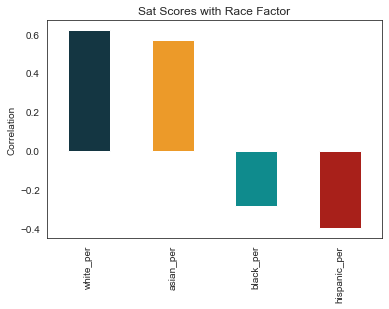

In [21]:
cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][cols].plot.bar(color = color3)
plt.title('Sat Scores with Race Factor')
plt.ylabel('Correlation')
plt.show()

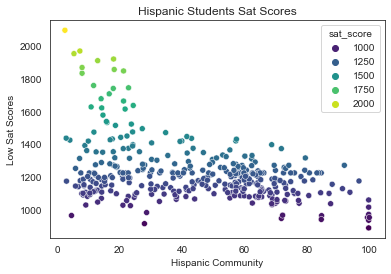

In [22]:
hispanic_viz = sns.scatterplot(data= combined, x= 'hispanic_per', y= 'sat_score', hue= 'sat_score', palette= color4) 
plt.title('Hispanic Students Sat Scores')
plt.xlabel('Hispanic Community')
plt.ylabel('Low Sat Scores')
plt.show()

    Majority with low grades

In [23]:
high_hispanic_ratio = combined[combined['hispanic_per'] > 95]
high_hispanic_ratio['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [24]:
low_hispanic_ratio = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
low_hispanic_ratio['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Gender and SAT Scores Exploration

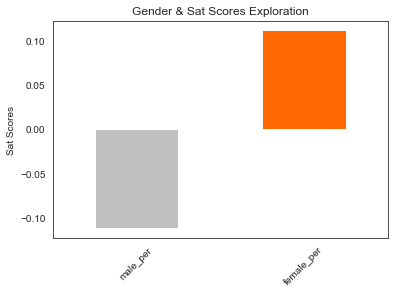

In [25]:
fm = ['male_per', 'female_per']
combined.corr()['sat_score'][fm].plot.bar(rot= 45, color = ['#c0c0c0', '#ff6700'])
plt.title('Gender & Sat Scores Exploration')
plt.ylabel('Sat Scores')
plt.show()

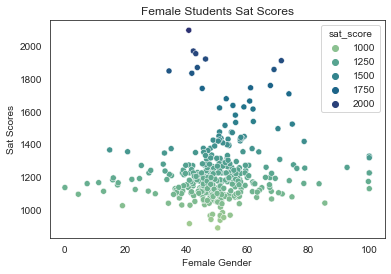

In [26]:
female_viz = sns.scatterplot(data= combined, x= 'female_per', y= 'sat_score', hue= 'sat_score', palette= color1)
plt.title('Female Students Sat Scores')
plt.xlabel('Female Gender')
plt.ylabel('Sat Scores')
plt.show()

In [27]:
high_female_ratio = combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"]
high_female_ratio

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Adavanced Placement & SAT Scores

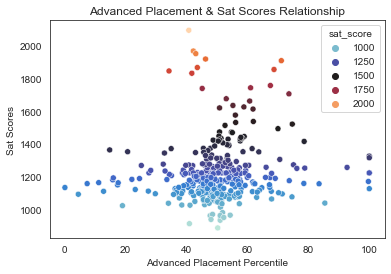

In [28]:
combined['ap_percentile'] = ((combined['AP Test Takers ']/combined['total_enrollment']) * 100)
ap_percentile_viz = sns.scatterplot(data= combined, x= 'female_per', y= 'sat_score', hue= 'sat_score', 
                                    palette= color5)
plt.title('Advanced Placement & Sat Scores Relationship')
plt.xlabel('Advanced Placement Percentile')
plt.ylabel('Sat Scores')
plt.show()

## Class Size & SAT Score Correlation

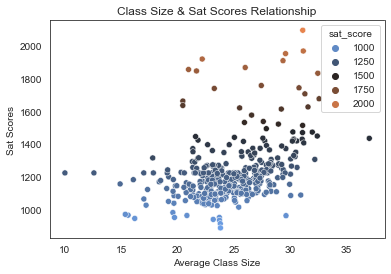

In [29]:
class_SAT_viz = sns.scatterplot(data= combined, x= 'AVERAGE CLASS SIZE', y= 'sat_score', hue= 'sat_score', 
                                palette= color6)
plt.title('Class Size & Sat Scores Relationship')
plt.xlabel('Average Class Size')
plt.ylabel('Sat Scores')
plt.show()

## Expensive Neighborhoods

In [30]:
for col in combined.columns:
    print(col)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [31]:
expens_neighbors = combined.groupby('boro').agg(np.mean)['sat_score']
expens_neighbors

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64

## School Grouping based on SAT Score
    Group1: Represents sat scores above 2000.
    Group2: Represents sat scores between 1500 & 2000.
    Gorup3: Represents sat scores between 1000 & 1500.
    Group4: Represents sat scores below 1000.
   

In [32]:
combined.shape

(363, 161)

In [33]:
combined['sat_score'].max()

2096.0

In [34]:
combined['sat_score'].min()

887.0

In [35]:
group_1 = combined[combined['sat_score'] > 2000]["SCHOOL NAME"]
group_2 = combined[(combined['sat_score'] > 1500) & (combined['sat_score'] < 2000)]['SCHOOL NAME']
group_3 = combined[(combined['sat_score'] > 1000) & (combined['sat_score'] < 1500)]['SCHOOL NAME']
group_4 = combined[(combined['sat_score'] < 1000)]['SCHOOL NAME']

In [65]:
# groups = []
# for g in groups:
#     if combined[combined['sat_score'] > 2000]["SCHOOL NAME"]:
#         g1 = groups.append(groups[g])
#     elif combined[(combined['sat_score'] > 1500) & (combined['sat_score'] < 2000)]['SCHOOL NAME']:
#         g2 = groups.append(groups[g])
#     elif combined[(combined['sat_score'] > 1000) & (combined['sat_score'] < 1500)]['SCHOOL NAME']:
#         g3 = groups.append(groups[g])
#     elif combined[(combined['sat_score'] < 1000)]['SCHOOL NAME']:
#         g4 = groups.append(groups[g])

In [64]:
#groups.keys()

In [66]:
#print(g1)

In [39]:
group_1

37    STUYVESANT HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [40]:
group_2

4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
5                         BARD HIGH SCHOOL EARLY COLLEGE
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
23                     BARUCH COLLEGE CAMPUS HIGH SCHOOL
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
304                      BENJAM

In [41]:
group_3

0          HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES
1                    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                             EAST SIDE COMMUNITY SCHOOL
3                                MARTA VALLE HIGH SCHOOL
6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
                             ...                        
358          EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK
359                   BUSHWICK SCHOOL FOR SOCIAL JUSTICE
360                            ACADEMY OF URBAN PLANNING
361                 ALL CITY LEADERSHIP SECONDARY SCHOOL
362    BUSHWICK LEADERS HIGH SCHOOL FOR ACADEMIC EXCE...
Name: SCHOOL NAME, Length: 327, dtype: object

In [42]:
group_4

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Assigning Ratings based on School Grouping
    Rating 'Excellent' represents schools with maxumum SAT score above 2000.
    Rating 'Good' represents schools with maxumum SAT score between 1500 & 2000.
    Rating 'Average' represents schools with maxumum SAT score between 1000 & 1500.
    Rating 'Poor' represents schools with maxumum SAT score below 1000.

In [43]:
# school_ratings = {}
# for school in groups:
#     school_ratings[school] = 'Excellent'
# for school in groups:
#     school_ratings[school] = 'Good'
# for school in groups:
#     school_ratings[school] = 'Average'
# for school in groups:
#     school_ratings[school] = 'Poor'

In [44]:
school_ratings = {}
for school in group_1:
    school_ratings[school] = 'Excellent'
for school in group_2:
    school_ratings[school] = 'Good'
for school in group_3:
    school_ratings[school] = 'Average'
for school in group_4:
    school_ratings[school] = 'Poor'

In [45]:
school_ratings

{'STUYVESANT HIGH SCHOOL': 'Excellent',
 'NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL': 'Good',
 'BARD HIGH SCHOOL EARLY COLLEGE': 'Good',
 'PROFESSIONAL PERFORMING ARTS HIGH SCHOOL': 'Good',
 'BARUCH COLLEGE CAMPUS HIGH SCHOOL': 'Good',
 'N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES': 'Good',
 'ELEANOR ROOSEVELT HIGH SCHOOL': 'Good',
 'MILLENNIUM HIGH SCHOOL': 'Good',
 'BEACON HIGH SCHOOL': 'Good',
 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS': 'Good',
 'HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE': 'Good',
 'BRONX HIGH SCHOOL OF SCIENCE': 'Good',
 'HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE': 'Good',
 'BROOKLYN TECHNICAL HIGH SCHOOL': 'Good',
 'BROOKLYN LATIN SCHOOL, THE': 'Good',
 'LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES': 'Good',
 'BARD HIGH SCHOOL EARLY COLLEGE II': 'Good',
 'TOWNSEND HARRIS HIGH SCHOOL': 'Good',
 'BENJAMIN N. CARDOZO HIGH SCHOOL': 'Good',
 "SCHOLARS' ACADEMY": 'Good',
 'QUEENS GATE

In [84]:
schools = pd.DataFrame.from_dict(school_ratings, orient= 'index', columns= ['school_score'])

In [85]:
schools = schools.rename_axis('School Name').reset_index('School Name')

In [87]:
schools.rename(columns={'school_score':'School Score'}, inplace= True)
schools

,School Name,School Score
0,STUYVESANT HIGH SCHOOL,Excellent
1,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",Good
2,BARD HIGH SCHOOL EARLY COLLEGE,Good
3,PROFESSIONAL PERFORMING ARTS HIGH SCHOOL,Good
4,BARUCH COLLEGE CAMPUS HIGH SCHOOL,Good
...,...,...
357,BROOKLYN INTERNATIONAL HIGH SCHOOL,Poor
358,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,Poor
359,IT TAKES A VILLAGE ACADEMY,Poor
360,MULTICULTURAL HIGH SCHOOL,Poor
